In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [3]:
print("Number of training steps:", n_epochs * len(train_loader))

Number of training steps: 4680


In [4]:
data = next(iter(train_loader))
x, y = data
print(f"data.shape: {x.shape}, labels.shape: {y.shape}")



data.shape: torch.Size([128, 1, 28, 28]), labels.shape: torch.Size([128])


In [5]:
def gen(model, node, use_torch_diffeq):
    generated_class_list = torch.arange(10, device=device).repeat(10)
    with torch.no_grad():
        if use_torch_diffeq:
            _samples = torch.randn(100, 1, 28, 28, device=device)
            _int_span = torch.linspace(0, 1, 2, device=device)
            print("samples:", _samples.shape)
            print("int_span:", _int_span.shape)
            print("generated_class_list:", generated_class_list.shape)
            traj = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x, generated_class_list),
                _samples,
                _int_span,
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
        else:
            traj = node.trajectory(
                torch.randn(100, 1, 28, 28, device=device),
                t_span=torch.linspace(0, 1, 2, device=device),
            )
    grid = make_grid(
        traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
    )
    img = ToPILImage()(grid)
    plt.imshow(img)
    plt.show()

In [6]:
def train_mnist(train_loader, model, FM, optimizer, use_ot, modelname):
    # look for checkpoint
    cp = f"{savedir}/{modelname}.pth"
    
    if os.path.exists(cp):
        model.load_state_dict(torch.load(cp))
        print("Loaded model")
        
    else:
        print("Training model")
        for epoch in range(n_epochs):
            for i, data in enumerate(train_loader):
                optimizer.zero_grad()
                x1 = data[0].to(device)
                y = data[1].to(device)  # class labels
                # sample source distribution
                x0 = torch.randn_like(x1)  # random noise
                
                if i == 0:
                    print(f"x1.shape: {x1.shape}, y.shape: {y.shape}")
                
                # Flow Matching
                if use_ot:
                    t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(x0, x1, y1=y)
                    vt = model(t, xt, y1)
                else:
                    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
                    vt = model(t, xt, y)
                
                loss = torch.mean((vt - ut) ** 2)
                # Backprop
                loss.backward()
                optimizer.step()
                print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")
                
        # save model
        torch.save(model.state_dict(), cp)

#################################
#    Class Conditional CFM
#################################

In [7]:


sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# Target FM (Lipman et al. 2023)
# FM = TargetConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [8]:
train_mnist(
    train_loader=train_loader, 
    model=model, 
    FM=FM, 
    optimizer=optimizer, 
    use_ot=False, 
    modelname="mnist_model"
)

/tmp/ipykernel_1104491/2983961547.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cp))


Loaded model


samples: torch.Size([100, 1, 28, 28])
int_span: torch.Size([2])
generated_class_list: torch.Size([100])


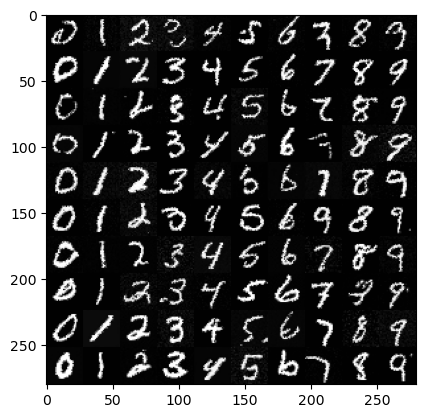

In [9]:
USE_TORCH_DIFFEQ = True
gen(model, node, USE_TORCH_DIFFEQ)

#################################
#            OT-CFM
#################################

In [10]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [11]:
train_mnist(
    train_loader=train_loader, 
    model=model, 
    FM=FM, 
    optimizer=optimizer, 
    use_ot=True, 
    modelname="mnist_ot_model"
)


Loaded model


/tmp/ipykernel_1104491/2983961547.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cp))


samples: torch.Size([100, 1, 28, 28])
int_span: torch.Size([2])
generated_class_list: torch.Size([100])


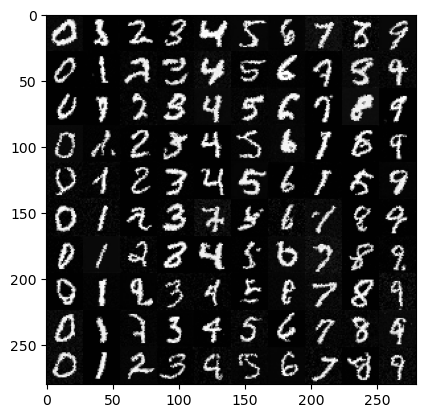

In [12]:
USE_TORCH_DIFFEQ = True
gen(model, node, USE_TORCH_DIFFEQ)

---

In [13]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1


model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
score_model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [14]:
# look for checkpoint
cp = f"{savedir}/mnist_sf2m_model.pth"

if os.path.exists(cp):
    model.load_state_dict(torch.load(cp))
    print("Loaded model")
else:
    print("Training model")
    for epoch in range(n_epochs):
        for i, data in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            x1 = data[0].to(device)
            y = data[1].to(device)
            x0 = torch.randn_like(x1)
            
            if i == 0:
                print(f"x1.shape: {x1.shape}, y.shape: {y.shape}")
            
            t, xt, ut, _, y1, eps = FM.guided_sample_location_and_conditional_flow(
                x0, x1, y1=y, return_noise=True
            )
            lambda_t = FM.compute_lambda(t)
            vt = model(t, xt, y1)
            st = score_model(t, xt, y1)
            flow_loss = torch.mean((vt - ut) ** 2)
            score_loss = torch.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
            loss = flow_loss + score_loss
            loss.backward()
            optimizer.step()
        
    # save model
    torch.save(model.state_dict(), cp)


/tmp/ipykernel_1104491/1451708857.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cp))


Loaded model


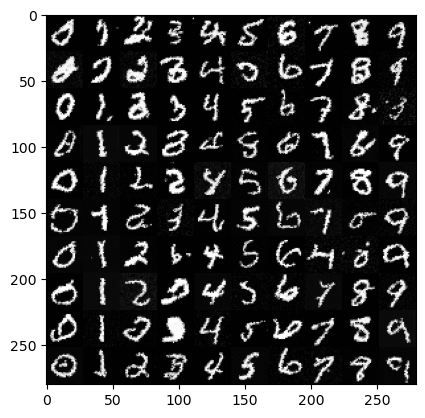

In [15]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)

node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
# Evaluate the ODE
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [16]:
# follows example from https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, labels=None, reverse=False, sigma=0.1):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.reverse = reverse
        self.labels = labels
        self.sigma = sigma

    # Drift

    def f(self, t, y):
        y = y.view(-1, 1, 28, 28)
        if self.reverse:
            t = 1 - t
            return -self.drift(t, y, self.labels) + self.score(t, y, self.labels)
        return self.drift(t, y, self.labels).flatten(start_dim=1) + self.score(
            t, y, self.labels
        ).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma

In [17]:
sde = SDE(model, score_model, labels=torch.arange(10, device=device).repeat(10), sigma=0.1)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        # x0.view(x0.size(0), -1),
        torch.randn(100, 1 * 28 * 28, device=device),
        ts=torch.linspace(0, 1, 2, device=device),
        dt=0.01,
    )

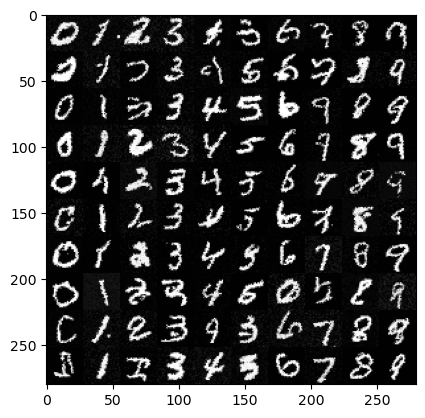

In [18]:
grid = make_grid(
    sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)